In [1]:
import numpy as np
import pickle
from copy import deepcopy
from itertools import chain
from collections import OrderedDict
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300
from IPython.display import display, HTML
import sys, os
sys.path.append(os.path.join(os.path.dirname("__file__"), '..', '..', '..'))
from AI_scientist.prepare_dataset import Dataset_Gen
from AI_scientist.util import plot_matrices, make_dir, get_struct_str, get_args, Early_Stopping, record_data, manifold_embedding, get_args, make_dir, sort_two_lists, get_highlight_fun
from AI_scientist.settings.filepath import variational_model_PATH, dataset_PATH
from AI_scientist.settings.global_param import COLOR_LIST
from AI_scientist.pytorch.net import Net, load_model_dict_net
from AI_scientist.pytorch.util_pytorch import to_Variable, to_np_array
from AI_scientist.variational.util_variational import sort_datapoints, get_torch_tasks
from AI_scientist.variational.variational_meta_learning import Master_Model, Statistics_Net, Generative_Net, load_model_dict, plot_quick_learn_performance, quick_learn
from AI_scientist.variational.variational_meta_learning import VAE_Loss, sample_Gaussian, clone_net, get_nets, get_tasks, evaluate, get_reg, load_trained_models, get_relevance
from AI_scientist.variational.variational_meta_learning import plot_task_ensembles, plot_individual_tasks, plot_statistics_vs_z, plot_data_record
from AI_scientist.variational.variational_meta_learning import plot_few_shot_loss, plot_individual_tasks_bounce
from AI_scientist.variational.variational_meta_learning import get_latent_model_data, get_polynomial_class, get_Legendre_class, get_master_function
import torch
import torch.nn as nn
from torch.autograd import Variable

is_cuda = torch.cuda.is_available()

In [2]:
def plot_quick_learn_curve(mse_list_all, num_tasks_test):
    plt.figure(figsize = (8,6))
    mse_list_all = np.array(mse_list_all)
    if not np.any(np.isnan(mse_list_all)):
        mse_mean = mse_list_all.mean(0)
        mse_std = mse_list_all.std(0)

        plt.fill_between(range(len(mse_mean)), mse_mean - mse_std * 1.96 / np.sqrt(int(num_tasks_test / 100)), mse_mean + mse_std * 1.96 / np.sqrt(num_tasks_test / 100), alpha = 0.3)
        plt.plot(range(len(mse_mean)), mse_mean)
        plt.title("few-shot regression", fontsize = 20)
        plt.xlabel("Number of gradient steps", fontsize = 18)
        plt.ylabel("Mean Squared Error", fontsize = 18)
        plt.show()
    else:
        print("NaN encouncered!")

def parse_dict(filename):
    filename_split = filename.split("_")
    data_dict = {}
    filename_split = filename.split("_")
    data_dict["exp_mode"] = filename_split[1]
    data_dict["task_id"] = eval(filename_split[2])[0]
    data_dict["input_size"] = filename_split[filename_split.index("input") + 1]
    data_dict["statistics_output_neurons"] = filename_split[filename_split.index("stat") + 1]
    data_dict["pre_pooling_neurons"] = filename_split[filename_split.index("pre") + 1]
    data_dict["num_context_neurons"] = filename_split[filename_split.index("context") + 1]
    data_dict["statistics_pooling"] = filename_split[filename_split.index("pool") + 1]
#     data_dict["batch_size_task"] = filename_split[filename_split.index("batch") + 1]
#     data_dict["num_backwards"] = filename_split[filename_split.index("back") + 1]
    if "hid" in filename_split:
        data_dict["main_hidden_neurons"] = eval(filename_split[filename_split.index("hid") + 1])
        data_dict["struct_param_pre_neurons"] = eval(filename_split[filename_split.index("hid") + 2])
        data_dict["struct_param_gen_base_neurons"] = eval(filename_split[filename_split.index("hid") + 3])
    data_dict["is_VAE"] = eval(filename_split[filename_split.index("VAE") + 1])
    data_dict["VAE_beta"] = filename_split[filename_split.index("VAE") + 2]
    data_dict["lr"] = filename_split[filename_split.index("lr") + 1]
    data_dict["reg_amp"] = filename_split[filename_split.index("reg") + 1]
    data_dict["activation_gen"] = filename_split[filename_split.index("actgen") + 1]
    data_dict["activation_model"] = filename_split[filename_split.index("actmodel") + 1]
    if "struct" in filename_split:
        data_dict["struct_string"] = filename_split[filename_split.index("struct") + 1]
    data_dict["loss_core"] = filename_split[filename_split.index("core") + 1]
    data_dict["main_hidden_neurons"] = eval(filename_split[filename_split.index("hid") + 1])
    if "uncer" in filename_split:
        data_dict["is_uncertainty"] = eval(filename_split[filename_split.index("uncer") + 1])
    optim_mode = filename_split[filename_split.index("core") - 1]
    if optim_mode in ["sum", "indi"]:
        data_dict["optim_mode"] = optim_mode
    if "pat" in filename_split:
        data_dict["patience"] = int(filename_split[filename_split.index("pat") + 1])
    if "for" in filename_split:
        data_dict["forward_steps"] = eval(filename_split[filename_split.index("for") + 1])
    data_dict["exp_id"] = filename_split[-1]
    data_dict["filename"] = filename
    return data_dict


def load_file(exp_id, filename):
    dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
    info_dict = pickle.load(open(dirname + filename, "rb"))
    data_record = info_dict["data_record"]
    data_dict = parse_dict(filename)
    master_model = load_model_dict(info_dict["model_dict"][-1])
    print("\n{0}".format(filename))

    data_dict["mse_few_shot"] = plot_few_shot_loss(master_model, tasks_test)
    plot_data_record(info_dict["data_record"], is_VAE = is_VAE)
    data_dict["mean_last"] = np.mean(data_record['mse_mean_test'][-6:-1])
    data_dict["median_last"] = np.mean(data_record['mse_median_test'][-6:-1])
    data_dict["mean_min"] = np.min(data_record['mse_mean_test'])
    data_dict["median_min"] = np.min(data_record['mse_median_test'])
    print("mean_last: {0:6f}\tmean_min: {1:.6f}\tmedian_last: {2:.6f}\tmedian_min: {3:.6f}".format(data_dict["mean_last"], data_dict["mean_min"], data_dict["median_last"], data_dict["median_min"]))
    statistics_list_test, z_list_test = plot_task_ensembles(tasks_test, master_model.statistics_Net, master_model.generative_Net, is_VAE = is_VAE, title = "y_pred_test vs. y_test")
    print("test statistics vs. z:")
    data_dict["corr_info"] = plot_statistics_vs_z(z_list_test, statistics_list_test)
    if "bounce" in task_id_list[0]:
        plot_individual_tasks_bounce(tasks_test, num_examples_show = 40, num_tasks_show = 9, master_model = master_model, num_shots = 200)
    else:
        _ = plot_individual_tasks(tasks_test, master_model.statistics_Net, master_model.generative_Net, is_VAE = is_VAE, xlim = task_settings["xlim"])
    return master_model, info_dict, data_dict


# See the general performance of all
def load_df(exp_id, task_id, exp_mode, num_test_tasks, min_shots = None, isplot = True):
    task_id_list = [task_id]
    is_oracle = (exp_mode == "oracle")
    dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
    data_dict_list = []
    i = 0
    is_time_series = True if "bounce" in task_id else False
    for filename in os.listdir(dirname):
        if "info" not in filename:
            continue
        try:
            info_dict = pickle.load(open(dirname + filename, "rb"))
        except:
            print("Cannot load {0}".format(filename))
        data_record = info_dict["data_record"]
        data_dict = parse_dict(filename)
        if task_id is not None:
            if task_id != data_dict["task_id"]:
                continue
        if exp_mode != data_dict["exp_mode"]:
            continue
        if data_dict["exp_mode"] == "meta": 
            master_model = load_model_dict(info_dict["model_dict"][-1])
            model = None
            data_dict["mse_few_shot"] = plot_few_shot_loss(model, tasks_test, min_shots = min_shots)
        elif data_dict["exp_mode"] in ["finetune", "baseline", "oracle"]:
            print(filename)
            model = load_model_dict_net(info_dict["model_dict"][-1])
            master_model = None
            data_dict["mse_few_shot"] = [None]
        print("\n{0}\t{1}".format(i, filename))

        if isplot:
            plot_data_record(info_dict["data_record"], is_VAE = data_dict["is_VAE"])
        data_dict["mean_last"] = np.mean(data_record['mse_mean_test'][-4:-1])
        data_dict["median_last"] = np.mean(data_record['mse_median_test'][-4:-1])
        data_dict["mean_min"] = np.min(data_record['mse_mean_test'])
        data_dict["median_min"] = np.min(data_record['mse_median_test'])
        if "mse_test" in info_dict or "mse_test_lr_0.001" in info_dict:
            try:
                data_dict["mse_test"] = info_dict["mse_test"]
            except:
                data_dict["mse_test"] = info_dict["mse_test_lr_0.001"]
            mse_mean = np.array(data_dict["mse_test"]).mean(0)
            data_dict["mse_test_0"] = mse_mean[0]
            data_dict["mse_test_5"] = mse_mean[5]
            data_dict["mse_test_10"] = mse_mean[10]
            data_dict["mse_test_20"] = mse_mean[20]
            if isplot:
                plot_quick_learn_curve(data_dict["mse_test"], num_test_tasks, is_time_series = is_time_series)
        print("mean_last: {0:6f}\tmean_min: {1:.6f}\tmedian_last: {2:.6f}\tmedian_min: {3:.6f}".format(data_dict["mean_last"], data_dict["mean_min"], data_dict["median_last"], data_dict["median_min"]))
        if data_dict["exp_mode"] == "meta": 
            statistics_list_test, z_list_test = plot_task_ensembles(tasks_test, master_model = master_model, model = model, is_time_series = is_time_series, is_VAE = data_dict["is_VAE"], title = "y_pred_test vs. y_test", isplot = isplot)
            print("test statistics vs. z:")
            if isplot:
                data_dict["corr_info"] = plot_statistics_vs_z(z_list_test, statistics_list_test)
        if isplot:
            if "bounce" in task_id_list[0]:
                if data_dict["exp_mode"] == "meta": 
                    plot_individual_tasks_bounce(tasks_test, num_examples_show = 40, num_tasks_show = 9, is_time_series = is_time_series, master_model = master_model, model = model, num_shots = 200)
                elif data_dict["exp_mode"] == "baseline":
                    plot_individual_tasks_bounce(tasks_test, num_examples_show = 40, num_tasks_show = 9, is_time_series = is_time_series, master_model = master_model, model = model, num_shots = 200)
            else:
                _ = plot_individual_tasks(tasks_test, master_model = master_model, model = model, is_time_series = is_time_series, is_VAE = data_dict["is_VAE"], is_oracle = is_oracle, xlim = (-5, 5))
        data_dict_list.append(data_dict)
        i += 1
    df = pd.DataFrame(data_dict_list)
    df = df.sort_values(by = "median_last")
    return df


def visualize_file(filename, exp_id, task_id, exp_mode, num_test_tasks, min_shots = 100, num_examples_show = 15, target_forward_steps = 1, eval_forward_steps = 1, isplot = True):
    task_id_list = [task_id]
    dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
    try:
        info_dict = pickle.load(open(dirname + filename, "rb"))
    except:
        raise
        print("Cannot load {0}".format(filename))
    data_record = info_dict["data_record"]
    data_dict = parse_dict(filename)
    if data_dict["exp_mode"] == "meta": 
        master_model = load_model_dict(info_dict["model_dict"][-1])
        model = None
        data_dict["mse_few_shot"] = plot_few_shot_loss(model, tasks_test, min_shots = min_shots)
    elif data_dict["exp_mode"] in ["finetune", "baseline", "oracle"]:
        print(filename)
        model = load_model_dict_net(info_dict["model_dict"][-1])
        master_model = None
        data_dict["mse_few_shot"] = [None]
    print("\n{0}\t{1}".format(i, filename))

    if isplot:
        plot_data_record(info_dict["data_record"], is_VAE = data_dict["is_VAE"])
    data_dict["mean_last"] = np.mean(data_record['mse_mean_test'][-4:-1])
    data_dict["median_last"] = np.mean(data_record['mse_median_test'][-4:-1])
    data_dict["mean_min"] = np.min(data_record['mse_mean_test'])
    data_dict["median_min"] = np.min(data_record['mse_median_test'])
    if "mse_test" in info_dict:
        data_dict["mse_test"] = info_dict["mse_test"]
        mse_mean = np.array(info_dict["mse_test"]).mean(0)
        data_dict["mse_test_0"] = mse_mean[0]
        data_dict["mse_test_5"] = mse_mean[5]
        data_dict["mse_test_10"] = mse_mean[10]
        data_dict["mse_test_20"] = mse_mean[20]
        if isplot:
            plot_quick_learn_curve(data_dict["mse_test"], num_test_tasks)
    print("mean_last: {0:6f}\tmean_min: {1:.6f}\tmedian_last: {2:.6f}\tmedian_min: {3:.6f}".format(data_dict["mean_last"], data_dict["mean_min"], data_dict["median_last"], data_dict["median_min"]))
    if data_dict["exp_mode"] == "meta": 
        statistics_list_test, z_list_test = plot_task_ensembles(tasks_test, master_model = master_model, model = model, is_VAE = data_dict["is_VAE"], title = "y_pred_test vs. y_test", isplot = isplot)
        print("test statistics vs. z:")
        if isplot:
            data_dict["corr_info"] = plot_statistics_vs_z(z_list_test, statistics_list_test)
    if isplot:
        if "bounce" in task_id_list[0]:
            if data_dict["exp_mode"] == "meta": 
                plot_individual_tasks_bounce(tasks_test, num_examples_show = num_examples_show, num_tasks_show = 9, master_model = master_model, model = model, num_shots = 200, eval_forward_steps = eval_forward_steps, target_forward_steps = target_forward_steps, highlight_top = 10)
            elif data_dict["exp_mode"] == "baseline":
                plot_individual_tasks_bounce(tasks_test, num_examples_show = num_examples_show, num_tasks_show = 9, master_model = master_model, model = model, num_shots = 200, eval_forward_steps = eval_forward_steps, target_forward_steps = target_forward_steps)
        else:
            _ = plot_individual_tasks(tasks_test, master_model = master_model, model = model, is_VAE = data_dict["is_VAE"], is_oracle = is_oracle, xlim = (-5, 5))



def get_dataset(task_id, exp_mode, num_test_tasks = None, num_forward_steps = None):
    task_id_list = [task_id]
    num_train_tasks = 100

    if task_id_list[0] in ["C-sin", "C-tanh"]:
        statistics_output_neurons = 2 if task_id_list[0] == "C-sin" else 4
        z_size = 2 if task_id_list[0] == "C-sin" else 4
        num_shots = 10
        input_size = 1
        output_size = 1
        if num_test_tasks is None:
            num_test_tasks = 200
    elif task_id_list[0] == "bounce-states":
        statistics_output_neurons = 8
        num_shots = 100
        z_size = 8
        input_size = 6
        output_size = 2
        if num_test_tasks is None:
            num_test_tasks = 200
    elif task_id_list[0] == "bounce-images":
        raise
    is_oracle = (exp_mode == "oracle")
    if is_oracle:
        input_size += z_size

    dataset_filename = dataset_PATH + task_id_list[0] + "_{0}-shot.p".format(num_shots)
    tasks = pickle.load(open(dataset_filename, "rb"))
    tasks_train = get_torch_tasks(tasks["tasks_train"], task_id_list[0], num_forward_steps = 1, is_oracle = is_oracle, is_cuda = is_cuda)
    tasks_test = get_torch_tasks(tasks["tasks_test"], task_id_list[0], start_id = num_train_tasks, num_tasks = num_test_tasks, num_forward_steps = num_forward_steps, is_oracle = is_oracle, is_cuda = is_cuda)
    return tasks_train, tasks_test

if "df" not in locals():
    df = {}
if "df_core" not in locals():
    df_core = {}
column_list_plus = ["mean_last", "mean_min", "median_last", "median_min", "mse_test_0", "mse_test_5","mse_test_10","mse_test_20","filename", "pre_pooling_neurons", "statistics_output_neurons", "is_VAE", "loss_core", "lr", "main_hidden_neurons", "struct_param_pre_neurons", "struct_param_gen_base_neurons", "num_context_neurons", "patience", "mse_test"]
column_list = ["mean_last", "mean_min", "median_last", "median_min","filename", "pre_pooling_neurons", "statistics_output_neurons", "is_VAE", "loss_core", "lr", "main_hidden_neurons", "struct_param_pre_neurons", "struct_param_gen_base_neurons", "num_context_neurons", "patience"]

## Sin exp:

In [3]:
colors = {"meta": "b",
          "maml": "orange",
          "oracle": "r",
          "finetune": "g"}
labels = {"meta": "MeLA (ours)",
          "maml": "MAML",
          "oracle": "oracle",
          "finetune": "pretrained",
         }
keys = ["meta", "maml", "oracle", "finetune"]

In [5]:
# For meta:
exp_id = "syn1.05"  # First experiment
task_id = "C-sin"
exp_mode = "meta"
dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
filename = "Net_meta_('C-sin',)_input_1_(100,100)_stat_2_pre_200_pool_max_context_0_hid_(40, 40)_(60, 3)_(60, 2)_VAE_False_0.2_uncer_False_lr_0.0005_reg_1e-06_actgen_leakyRelu_actmodel_leakyRelu_indi_core_huber_pat_400_for_1_syn1.05_info.p"
info_dict = pickle.load(open(dirname + filename, "rb"))
models = {}
models["meta"] = load_model_dict(info_dict["model_dict"][-1])
mse_test_meta = np.array(info_dict["mse_test_lr_0.001"])

# For finetune:
exp_id = "syn1.11"  # First experiment
task_id = "C-sin"
exp_mode = "finetune"
dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
filename = "Net_finetune_('C-sin',)_input_1_(100,100)_stat_2_pre_200_pool_max_context_0_hid_(40, 40)_(120, 3)_(60, 3)_VAE_False_0.2_uncer_False_lr_0.0005_reg_1e-06_actgen_leakyRelu_actmodel_leakyRelu_indi_core_huber_pat_400_for_1_syn1.11_info.p"
info_dict = pickle.load(open(dirname + filename, "rb"))
models["finetune"] = load_model_dict_net(info_dict["model_dict"][-1])
mse_test_finetune = np.array(info_dict["mse_test_lr_0.001"])

# For oracle:
exp_id = "syn1.11"  # First experiment
task_id = "C-sin"
exp_mode = "oracle"
dirname = variational_model_PATH + "/trained_models/{0}_good/".format(exp_id)
filename = "Net_oracle_('C-sin',)_input_3_(100,100)_stat_2_pre_200_pool_max_context_0_hid_(40, 40)_(120, 3)_(60, 3)_VAE_False_0.2_uncer_False_lr_0.0005_reg_1e-06_actgen_leakyRelu_actmodel_leakyRelu_indi_core_huber_pat_400_for_1_syn1.11_info.p"
info_dict = pickle.load(open(dirname + filename, "rb"))
mse_test_oracle = np.array(info_dict["mse_test_lr_0.001"])

# maml:
maml = np.loadtxt(open(variational_model_PATH + "/trained_models/" +  "{0}_maml.csv".format(task_id), "rb"), delimiter=",", skiprows=1)

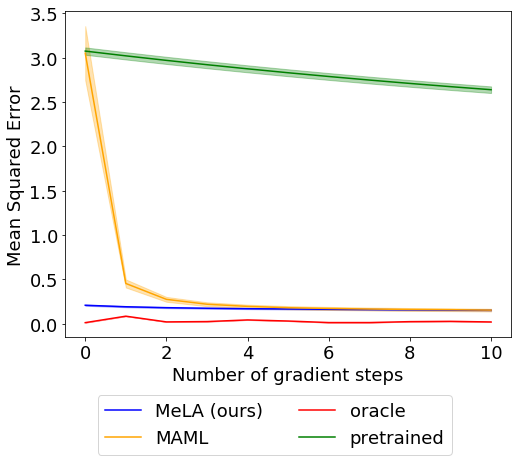

In [21]:
mse_list_all = mse_test_meta
num_tasks_test = 20000
Dict = OrderedDict()
Dict["meta"] = [mse_test_meta.mean(0), mse_test_meta.std(0) * 1.96 / np.sqrt(int(num_tasks_test / 100))]
Dict["finetune"] = [mse_test_finetune.mean(0), mse_test_finetune.std(0) * 1.96 / np.sqrt(int(num_tasks_test / 100))]
Dict["oracle"] = [mse_test_oracle.mean(0), mse_test_oracle.std(0) * 1.96 / np.sqrt(int(num_tasks_test / 100))]
Dict["maml"] = [maml[:,1], maml[:,2]]

plt.figure(figsize = (8,6))
begin = 0
end = 11
for i, key in enumerate(keys):
    (mse_mean, mse_conf) = Dict[key]
    mse_mean = mse_mean[begin:end]
    mse_conf = mse_conf[begin:end]
    plt.fill_between(range(len(mse_mean)), mse_mean - mse_conf, mse_mean + mse_conf, alpha = 0.3, color = colors[key])
    plt.plot(range(len(mse_mean)), mse_mean, label = labels[key], color = colors[key])
    plt.xlabel("Number of gradient steps", fontsize = 18)
    plt.ylabel("Mean Squared Error", fontsize = 18)
# plt.legend(fontsize = 18)
plt.legend(fontsize = 18, bbox_to_anchor = [0.22,-0.65, 0.5, 0.5], loc=9,ncol=2)
ax = plt.gca()
ax.tick_params(axis='both', labelsize = 18)
plt.savefig("fig_sin_quicklearn.pdf",  bbox_inches='tight')
plt.show()

In [22]:
task_id = "C-sin"
exp_mode = "meta"
tasks_train, tasks_test = get_dataset(task_id, exp_mode)
task_key = 'C-sin_103'
# task_key = 'C-sin_103' #Use for final
task = tasks_test[task_key]

((X_train, y_train), (X_test, y_test)), info = task
print(info)

{'z': array([3.60254326, 2.56683831])}


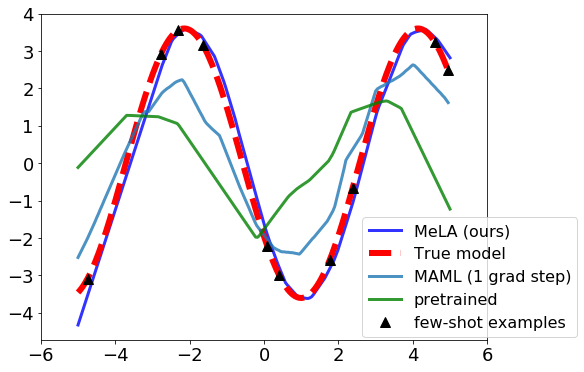

In [24]:
# 0 gradient steps:
linewidth = 3
alpha = 0.8

plt.figure(figsize = (8,6))
key = "meta"
X_linspace = np.linspace(-5,5,200)
X_linspace_torch = to_Variable(X_linspace).unsqueeze(1)
z = info["z"]
y_true = z[0] * np.sin(X_linspace - z[1])
results_meta = models["meta"].get_predictions(X_linspace_torch, X_train, y_train, is_time_series = False)

plt.plot(X_linspace, to_np_array(results_meta["y_pred"]), colors[key],label = labels[key], linewidth = linewidth, alpha = alpha)
plt.plot(X_linspace, y_true, "r--", label = "True model", linewidth = 6, alpha = 1)
key = "finetune"
y_pred_finetune = models["finetune"](X_linspace_torch)

plt.plot(A[:,0], A[:,1], linewidth = linewidth, alpha = alpha, label = "MAML (1 grad step)")
plt.plot(X_linspace, to_np_array(y_pred_finetune), colors[key], label = labels[key], linewidth = linewidth, alpha = alpha)
plt.plot(to_np_array(X_train), to_np_array(y_train), "k^", markersize = 10, label = "few-shot examples")
plt.legend(fontsize = 16, bbox_to_anchor = [0.82,0.,0.4,0.4])
plt.xlim([-6,6])
# plt.xlabel("Number of gradient steps", fontsize = 18)
# plt.ylabel("Mean Squared Error", fontsize = 18)
ax = plt.gca()
ax.tick_params(axis='both', labelsize = 18)
plt.savefig("fig_sin_0_step.pdf", bbox_inches='tight')
plt.show()

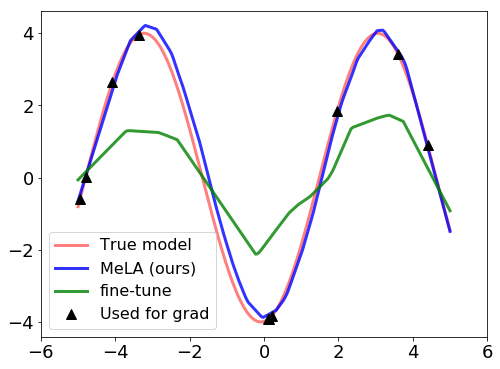

In [93]:
# multi gradient steps:
num_gradient_steps = 5
linewidth = 3
alpha = 0.8

plt.figure(figsize = (8,6))
key = "meta"
X_linspace = np.linspace(-5,5,200)
X_linspace_torch = to_Variable(X_linspace).unsqueeze(1)
z = info["z"]
y_true = z[0] * np.sin(X_linspace - z[1])
model = models[key]
_, new_model = quick_learn(model.get_clone_net(X_train, y_train), X_train, y_train, (X_test, y_test), forward_steps = [1], is_time_series = False, loss_core = "huber", batch_size = 128, epochs = num_gradient_steps, lr = 1e-3, optim_type = "adam")
y_pred_meta = new_model(X_linspace_torch)

plt.plot(X_linspace, y_true, "r", label = "True model", linewidth = linewidth, alpha = 0.5)
plt.plot(X_linspace, to_np_array(y_pred_meta), colors[key], label = labels[key], linewidth = linewidth, alpha = alpha)
plt.plot()
key = "finetune"
model = models[key]
_, new_model = quick_learn(model, X_train, y_train, (X_test, y_test), forward_steps = [1], is_time_series = False, loss_core = "huber", batch_size = 128, epochs = num_gradient_steps, lr = 1e-3, optim_type = "adam")
y_pred_finetune = new_model(X_linspace_torch)

plt.plot(X_linspace, to_np_array(y_pred_finetune), colors[key], label = labels[key], linewidth = linewidth, alpha = alpha)
plt.plot(to_np_array(X_train), to_np_array(y_train), "k^", markersize = 10,  label = "Used for grad")
plt.legend(fontsize = 16)
plt.xlim([-6,6])
# plt.xlabel("Number of gradient steps", fontsize = 18)
# plt.ylabel("Mean Squared Error", fontsize = 18)
ax = plt.gca()
ax.tick_params(axis='both', labelsize = 18)
plt.savefig("fig_sin_{0}_step.eps".format(num_gradient_steps))
plt.show()

## Identify example influence:

In [52]:
task_id = "C-sin"
exp_mode = "meta"
tasks_train, tasks_test = get_dataset(task_id, exp_mode)
task_key = 'C-sin_143'
# task_key = 'C-sin_143' #Use for final
task = tasks_test[task_key]

((X_train, y_train), (X_test, y_test)), info = task
print(info)

{'z': array([3.70658416, 0.5211667 ])}


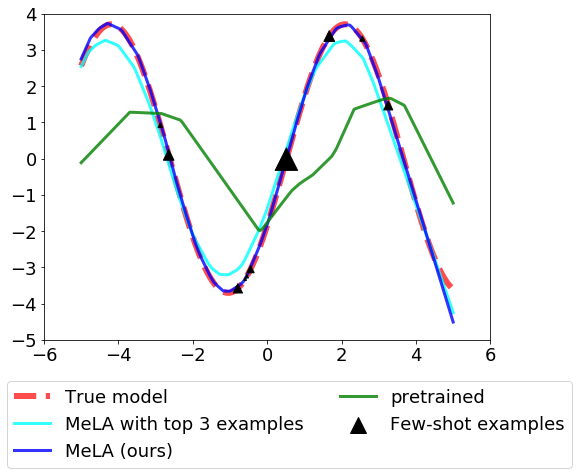

In [64]:
model = models["meta"]
statistics_Net = model.statistics_Net
generative_Net = model.generative_Net

plt.figure(figsize = (8,6))
X_linspace = np.linspace(-5,5,200)
X_linspace_torch = to_Variable(X_linspace).unsqueeze(1)

# True model:
z = info["z"]
y_true = z[0] * np.sin(X_linspace - z[1])
plt.plot(X_linspace, y_true, "r--", label = "True model", linewidth = 6, alpha = 0.7)

# Top 3:
top = 3
relevance_train = get_relevance(X_train, y_train, statistics_Net)
X_sorted, y_sorted, relevance_sorted = sort_datapoints(X_train, y_train, relevance_train, top = top)
results = model.get_predictions(X_linspace_torch, X_sorted, y_sorted, is_time_series = False)
plt.plot(X_linspace, to_np_array(results["y_pred"]), c = "cyan", label = "MeLA with top 3 examples", linewidth = linewidth, alpha = alpha)

# Full 10:
results_meta = models["meta"].get_predictions(X_linspace_torch, X_train, y_train, is_time_series = False)
plt.plot(X_linspace, to_np_array(results_meta["y_pred"]), "b",label = "MeLA (ours)", linewidth = linewidth, alpha = alpha)

# Finetune:
key = "finetune"
model = models[key]
# _, new_model = quick_learn(model, X_train, y_train, (X_test, y_test), forward_steps = [1], is_time_series = False, loss_core = "huber", batch_size = 128, epochs = num_gradient_steps, lr = 1e-3, optim_type = "adam")
y_pred_finetune = model(X_linspace_torch)
plt.plot(X_linspace, to_np_array(y_pred_finetune), colors[key], label = labels[key], linewidth = linewidth, alpha = alpha)

# Data points:
plt.scatter(X_train.data.numpy(), y_train.data.numpy(),  s = 5 * relevance_train + 2, c = "k", alpha = 1, zorder = 3, marker = "^", label = "Few-shot examples")
# plt.scatter(X_sorted.data.numpy(), y_sorted.data.numpy(),  s = 5 * relevance_sorted + 2, c = "k", marker = "^",zorder = 5,  label = "Few shot examples")

# Plot settings:
# plt.legend(fontsize = 18, bbox_to_anchor = [0.76,0.75, 0.5,0.5])
plt.legend(fontsize = 18, bbox_to_anchor = [0.3,-0.6, 0.5, 0.5], loc=9,ncol=2)
plt.xlim([-6,6])
plt.ylim([-5,4])
ax = plt.gca()
ax.tick_params(axis='both', labelsize = 18)
plt.savefig("fig_influence.pdf", bbox_inches='tight')
plt.show()


In [16]:
# Prepare the two data points:
X_to_predict = -4
X_to_predict = Variable(torch.FloatTensor([[X_to_predict]]))

X_sorted, y_sorted, relevance_sorted = sort_datapoints(X_train, y_train, relevance_train, top = 10)
top = 2

X_current = X_sorted[:top]
y_current = y_sorted[:top]
X_left = X_sorted[top:]
y_left = y_sorted[top:]

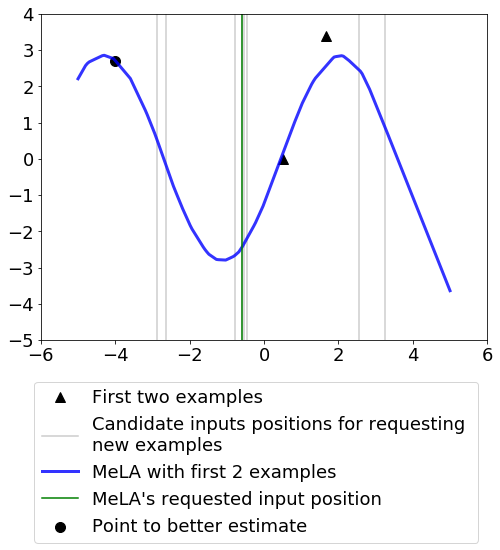

In [43]:
# def measure_next_point(X_to_predict, X_current, y_current, relevance_current, dataset, X_linspace_torch = None):
((X_train, y_train), (X_test, y_test)) , _ = task
model = models["meta"]

plt.figure(figsize = (8,6))
X_linspace = np.linspace(-5,5,200)
X_linspace_torch = to_Variable(X_linspace).unsqueeze(1)

# # True model:
# z = info["z"]
# y_true = z[0] * np.sin(X_linspace - z[1])
# plt.plot(X_linspace, y_true, "r", label = "True model", linewidth = linewidth, alpha = 0.4)

plt.plot(to_np_array(X_current), to_np_array(y_current), "k^", markersize = 10,  label = "First two examples")

# Data point to predict:
y_to_predict_estimate = model.get_predictions(X_to_predict, X_current, y_current, is_time_series = False)["y_pred"]
plt.scatter(to_np_array(X_to_predict), to_np_array(y_to_predict_estimate), s = 100, c = "k", marker = "o", label = "Point to better estimate")

for i, x in enumerate(to_np_array(X_left)):
    if i == 0:
        plt.axvline(x = x, c = "k", alpha = 0.2, label = "Candidate inputs positions for requesting \nnew examples")
    else:
        plt.axvline(x = x, c = "k", alpha = 0.2)
# plt.scatter(to_np_array(X_left), to_np_array(y_left), color = "k", marker = "^", s = 60,  alpha = 0.5, label = "Candidate points to measure")

# Plot current model:
results = model.get_predictions(X_linspace_torch, X_current, y_current, is_time_series = False)
plt.plot(to_np_array(X_linspace), to_np_array(results["y_pred"]), c = "b", label = "MeLA with first 2 examples", linewidth = linewidth, alpha = alpha)

# Get sensitivity of prediction point w.r.t. each training point:
sensitivity_list = get_sensitivity(statistics_Net, generative_Net, X_left, X_to_predict, X_current, y_current)
X_sensitivity_sorted, y_sensitivity_sorted, sensitivity_sorted = sort_datapoints(X_left, y_left, sensitivity_list.abs())
X_to_measure = X_sensitivity_sorted[:1]
y_to_measure = y_sensitivity_sorted[:1]

# Plot the next top point to measure:
plt.axvline(x = to_np_array(X_to_measure[0][0]), c = "g", label = "MeLA's requested input position")
# plt.scatter(to_np_array(X_to_measure), to_np_array(y_to_measure), s = 60, c = "g", label = "MeLA proposed new point to measure", zorder = 20)
# plt.title("Relevance of each example for determining the latent parameter z")

# # Plot the predictions after measuring the new point:
# X_with_new_measurement = deepcopy(torch.cat([X_current, X_to_measure]))
# y_with_new_measurement = deepcopy(torch.cat([y_current, y_to_measure]))

# results = model.get_predictions(X_linspace_torch, X_with_new_measurement, y_with_new_measurement, is_time_series = False)
# plt.plot(to_np_array(X_linspace), to_np_array(results["y_pred"]), "g--", label = "MeLA with obtained new examples", linewidth = linewidth, alpha = alpha)

# plt.legend(fontsize = 18, bbox_to_anchor = [0.9,0.9])
# plt.show()

plt.legend(fontsize = 18, bbox_to_anchor = [0.5,-0.6, 0.5, 0.5])
plt.xlim([-6,6])
plt.ylim([-5,4])
ax = plt.gca()
ax.tick_params(axis='both', labelsize = 18)
plt.savefig("fig_propose.pdf", bbox_inches='tight')
plt.show()

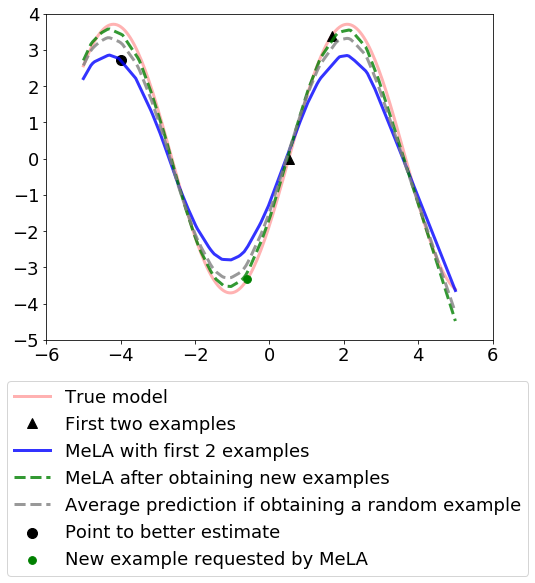

In [66]:
# def measure_next_point(X_to_predict, X_current, y_current, relevance_current, dataset, X_linspace_torch = None):
((X_train, y_train), (X_test, y_test)) , _ = task
model = models["meta"]

plt.figure(figsize = (8,6))
X_linspace = np.linspace(-5,5,200)
X_linspace_torch = to_Variable(X_linspace).unsqueeze(1)

# True model:
z = info["z"]
y_true = z[0] * np.sin(X_linspace - z[1])
plt.plot(X_linspace, y_true, "r", label = "True model", linewidth = 3, alpha = 0.3)

plt.plot(to_np_array(X_current), to_np_array(y_current), "k^", markersize = 10,  label = "First two examples")

# Data point to predict:
y_to_predict_estimate = model.get_predictions(X_to_predict, X_current, y_current, is_time_series = False)["y_pred"]
plt.scatter(to_np_array(X_to_predict), to_np_array(y_to_predict_estimate), s = 100, c = "k", marker = "o", label = "Point to better estimate")

# for i, x in enumerate(to_np_array(X_left)):
#     if i == 0:
#         plt.axvline(x = x, c = "k", alpha = 0.2, label = "candidate positions to inquire examples")
#     else:
#         plt.axvline(x = x, c = "k", alpha = 0.2)
# plt.scatter(to_np_array(X_left), to_np_array(y_left), color = "k", marker = "^", s = 60,  alpha = 0.5, label = "Candidate points to measure")

# Plot current model:
results = model.get_predictions(X_linspace_torch, X_current, y_current, is_time_series = False)
plt.plot(to_np_array(X_linspace), to_np_array(results["y_pred"]), c = "b", label = "MeLA with first 2 examples", linewidth = linewidth, alpha = alpha)

# Get sensitivity of prediction point w.r.t. each training point:
sensitivity_list = get_sensitivity(statistics_Net, generative_Net, X_left, X_to_predict, X_current, y_current)
X_sensitivity_sorted, y_sensitivity_sorted, sensitivity_sorted = sort_datapoints(X_left, y_left, sensitivity_list.abs())
X_to_measure = X_sensitivity_sorted[:1]
y_to_measure = y_sensitivity_sorted[:1]

# Plot the next top point to measure:
# plt.axvline(x = to_np_array(X_to_measure[0][0]), c = "g", label = "MeLA proposed input to obtain")
plt.scatter(to_np_array(X_to_measure), to_np_array(y_to_measure), s = 60, c = "g", label = "New example requested by MeLA", zorder = 20)
# plt.title("Relevance of each example for determining the latent parameter z")

# Plot the predictions after measuring the new point:
X_with_new_measurement = deepcopy(torch.cat([X_current, X_to_measure]))
y_with_new_measurement = deepcopy(torch.cat([y_current, y_to_measure]))


results = model.get_predictions(X_linspace_torch, X_with_new_measurement, y_with_new_measurement, is_time_series = False)
plt.plot(to_np_array(X_linspace), to_np_array(results["y_pred"]), "g--", label = "MeLA after obtaining new examples", linewidth = linewidth, alpha = alpha)

Y_record = []
for (x, y) in torch.cat([X_left, y_left], 1):
    X_with_new_measurement = deepcopy(torch.cat([X_current, x.unsqueeze(1)]))
    y_with_new_measurement = deepcopy(torch.cat([y_current, y.unsqueeze(1)]))

    y_would_be = model.get_predictions(X_linspace_torch, X_with_new_measurement, y_with_new_measurement, is_time_series = False)["y_pred"]
    Y_record.append(y_would_be)
Y_mean = torch.cat(Y_record,1).mean(1)
plt.plot(to_np_array(X_linspace), to_np_array(Y_mean), color = "grey", linestyle = "--",  label = "Average prediction if obtaining a random example", linewidth = linewidth, alpha = alpha)


# plt.legend(fontsize = 18, bbox_to_anchor = [0.9,0.9])
# plt.show()

plt.legend(fontsize = 18, bbox_to_anchor = [0.6,-0.6, 0.5, 0.5])
plt.xlim([-6,6])
plt.ylim([-5,4])
ax = plt.gca()
ax.tick_params(axis='both', labelsize = 18)
plt.savefig("fig_propose_after.pdf", bbox_inches='tight')
plt.show()